In [15]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from ddm.run_split import SplitMnistGenerator
from ddm.alg.cla_models_multihead import MFVI_IBP_NN, MFVI_NN, Vanilla_NN
from ddm.alg.utils import get_scores, concatenate_results
from ddm.alg.vcl import run_vcl
from copy import deepcopy

from bayes_opt import BayesianOptimization

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Weight pruning

In [16]:
class MFVI_IBP_NN_prune(MFVI_IBP_NN):
    def __init__(self, input_size, hidden_size, output_size, training_size, num_ibp_samples=10,
                 no_train_samples=10, no_pred_samples=100, prev_means=None, prev_log_variances=None,
                 prev_betas=None, learning_rate=0.0001,
                 prior_mean=0, prior_var=1, alpha0=5., beta0=1., lambda_1=1., lambda_2=1.,
                 tensorboard_dir='logs', name='ibp_wp', min_temp=0.5, tb_logging=True,
                output_tb_gradients=True):

        super(MFVI_IBP_NN_prune, self).__init__(input_size, hidden_size, output_size, training_size,
                 no_train_samples, no_pred_samples, num_ibp_samples, prev_means, prev_log_variances,
                 prev_betas, learning_rate,
                 prior_mean, prior_var, alpha0, beta0, lambda_1, lambda_2,
                 tensorboard_dir, name, min_temp, tb_logging, output_tb_gradients=True)


    def prune_weights(self, X_test, Y_test, task_id):
        """ Performs weight pruning.
        
        Z is at a data level doesn't make sense to introduce this intot he mask over weights which get zeroed 
        out. Simlpy running the accuracy over the graph will entail that Z is incorporated into the 
        matrix math for the prediction calculations.
        
        Args:
            X_test: numpy array
            Y_test: numpy array
            task_id: int
        :return: cutoffs, accs via naive pruning, accs via snr pruning,
        weight values, sigma values of network
        """

        def reset_weights(pr_mus, pr_sigmas, _mus, _sigmas):
            """ Reset weights of graph to original values
            Args:
                pr_mus: list of tf variables which have been pruned
                pr_sigmas: list of tf variables which have been pruned
                _mus: list of cached mus in numpy
                _sigmas: list of cached sigmas in numpy
            """

            for v, _v in zip(pr_mus, _mus):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

            for v, _v in zip(pr_sigmas, _sigmas):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

        def pruning(remove_pct, weightvalues, sigmavalues,
                    weights, sigmas, uncert_pruning=True):
            """ Performs weight pruning experiment
            Args:
                weightvalues: np array of weights
                sigmavalues: np array of sigmas
                weights: list of tf weight variable
                new_weights: list of new tf weight variables which wil
                sigmas: list of tf sigma variables
                uncert_pruning: bool pruning by snr
            """
            if uncert_pruning:
                sorted_STN = np.sort(np.abs(weightvalues) / sigmavalues)
                
            else:
                sorted_STN = np.sort(np.abs(weightvalues))
            cutoff = sorted_STN[int(remove_pct * len(sorted_STN))]
            
            # Weights, biases and head weights
            for v, s in zip(weights, sigmas):
                if uncert_pruning:
                    snr = tf.abs(v) / tf.exp(0.5*s)
                    mask = tf.greater_equal(snr, cutoff)
                else:
                    mask = tf.greater_equal(tf.abs(v), cutoff)
                self.sess.run(tf.assign(v, tf.multiply(v, tf.cast(mask, v.dtype))))
                #self.sess.run(tf.assign(s, np.multiply(self.sess.run(s), mask)))  # also apply zero std to weight!!!
                
            accs = []
            for _ in range(10):
                accs.append(self.sess.run(self.acc, {self.x: X_test,
                                                     self.y: Y_test,
                                                     self.task_idx: task_id,
                                                     self.temp: self.lambda_1,
                                                     self.training: False}))
            print("%.2f, %s" % (np.sum(sorted_STN < cutoff) / len(sorted_STN), np.mean(accs)))
            return np.mean(accs)

        # get weights
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # Get weights from network
        # TODO get head weights and biases
        mus_w = []
        mus_b = []
        sigmas_w = []
        sigmas_b = []
        mus_h = [] # weights and biases
        sigmas_h = [] # weights and biases
        for v in weights:
            if re.match("^([w])(_mu_)([0-9]+)(:0)$", v.name):
                mus_w.append(v)
            elif re.match("^([w])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_w.append(v)
            elif re.match("^([b])(_mu_)([0-9]+)(:0)$", v.name):
                mus_b.append(v)
            elif re.match("^([b])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_b.append(v)
            elif re.match("^([wb])(_mu_h_)([0-9]+)(:0)$", v.name):
                mus_h.append(v)
            elif re.match("^([wb])(_sigma_h_)([0-9]+)(:0)$", v.name):
                sigmas_h.append(v)
            else:
                print("Un-matched: {}".format(v.name))
                
        acc = self.sess.run(self.acc, {self.x: X_test,
                                    self.y: Y_test,
                                    self.task_idx: task_id,
                                    self.temp: self.lambda_1,
                                    self.training: False}) # z mask for each layer in a list, each Z \in dout
        print("test acc: {}".format(acc))
        # cache network weights of resetting the network
        _mus_w = [self.sess.run(w) for w in mus_w]
        _sigmas_w = [self.sess.run(w) for w in sigmas_w]
        _mus_b = [self.sess.run(w) for w in mus_b]
        _sigmas_b = [self.sess.run(w) for w in sigmas_b]
        _mus_h = [self.sess.run(w) for w in mus_h]
        _sigmas_h = [self.sess.run(w) for w in sigmas_h]
        
        weightvalues = np.hstack(np.array([self.sess.run(w).flatten() for w in mus_w + mus_b + mus_h]))
        sigmavalues = np.hstack(np.array([self.sess.run(tf.exp(0.5*s)).flatten() for s in sigmas_w + sigmas_b + sigmas_h]))
    
        xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
        ya_ibp = []
        for pct in xs:
            ya_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                              sigmas_w + sigmas_b + sigmas_h, uncert_pruning=False))

        # reset etc.
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        yb_ibp = []
        for pct in xs:
            yb_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                                  sigmas_w + sigmas_b + sigmas_h, uncert_pruning=True))
            
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        
        #return xs, ya, yb, ya_ibp, yb_ibp
        return xs, ya_ibp, yb_ibp

# Multiclass CLF Weight Pruning

In [17]:
class MnistGenerator():
    def __init__(self, max_iter=10):
        with gzip.open('ddm/data/mnist.pkl.gz', 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

        self.X_train = np.vstack((train_set[0], valid_set[0]))
        self.Y_train = np.hstack((train_set[1], valid_set[1]))
        self.X_test = test_set[0]
        self.Y_test = test_set[1]
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return self.X_train.shape[1], 10

    def task(self):
        # Retrieve train data
        x_train = deepcopy(self.X_train)
        y_train = np.eye(10)[self.Y_train]

        # Retrieve test data
        x_test = deepcopy(self.X_test)
        y_test = np.eye(10)[self.Y_test]
        
        return x_train, y_train, x_test, y_test

In [18]:
hidden_size = [100]
batch_size = 128
no_epochs = 600
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
    
tf.reset_default_graph()  
x_train, y_train, x_test, y_test = data_gen.task()
x_testsets.append(x_test)
y_testsets.append(y_test)

# Set the readout head to train
head = 0 if single_head else task_id
bsize = x_train.shape[0] if (batch_size is None) else batch_size

# Train network with maximum likelihood to initialize first model
if task_id == 0:
    ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
    ml_model.train(x_train, y_train, task_id, 100, bsize)
    mf_weights = ml_model.get_weights()
    mf_variances = None
    mf_betas = None
    ml_model.close_session()

# Train on non-coreset data
mf_model = MFVI_IBP_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], 
                             num_ibp_samples=10, prev_means=mf_weights, 
                       prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=5.0, beta0=1.0,
                       learning_rate=0.00005, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                       name='ibp_wp_mnist_new')

#mf_model.restore(os.path.join("logs", "graph_{}_task{}".format('ibp_wp_mnist', 0)))
mf_model.train(x_train, y_train, head, no_epochs, bsize,
              anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)

xs, ya_ibp, yb_ibp  = mf_model.prune_weights(x_test, y_test, head)

mf_model.close_session()

Epoch: 0001 cost= 0.426189762
Epoch: 0006 cost= 0.072720788
Epoch: 0011 cost= 0.034669463
Epoch: 0016 cost= 0.016965997
Epoch: 0021 cost= 0.009314988
Epoch: 0026 cost= 0.004378363
Epoch: 0031 cost= 0.002213837
Epoch: 0036 cost= 0.003966764
Epoch: 0041 cost= 0.000496028
Epoch: 0046 cost= 0.000379165
Epoch: 0051 cost= 0.007840798
Epoch: 0056 cost= 0.000209307
Epoch: 0061 cost= 0.004998238
Epoch: 0066 cost= 0.000127207
Epoch: 0071 cost= 0.009636767
Epoch: 0076 cost= 0.000103964
Epoch: 0081 cost= 0.000062058
Epoch: 0086 cost= 0.000225862
Epoch: 0091 cost= 0.000057764
Epoch: 0096 cost= 0.000036915
Optimization Finished!
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)


W0823 10:12:40.886374 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:965: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch: 0001 train cost= 5.082051569
Epoch: 0006 train cost= 4.157539167
Epoch: 0011 train cost= 3.840953959
Epoch: 0016 train cost= 3.657530600
Epoch: 0021 train cost= 3.520703846
Epoch: 0026 train cost= 3.411455073
Epoch: 0031 train cost= 3.317287026
Epoch: 0036 train cost= 3.229020371
Epoch: 0041 train cost= 3.141502507
Epoch: 0046 train cost= 3.059525423
Epoch: 0051 train cost= 2.978543582
Epoch: 0056 train cost= 2.899726366
Epoch: 0061 train cost= 2.822270789
Epoch: 0066 train cost= 2.744826163
Epoch: 0071 train cost= 2.669226631
Epoch: 0076 train cost= 2.592958947
Epoch: 0081 train cost= 2.516887579
Epoch: 0086 train cost= 2.444070041
Epoch: 0091 train cost= 2.371057842
Epoch: 0096 train cost= 2.299650514
Epoch: 0101 train cost= 2.227184163
Epoch: 0106 train cost= 2.156400211
Epoch: 0111 train cost= 2.083965830
Epoch: 0116 train cost= 2.014614938
Epoch: 0121 train cost= 1.945414134
Epoch: 0126 train cost= 1.876466762
Epoch: 0131 train cost= 1.808496328
Epoch: 0136 train cost= 1.74

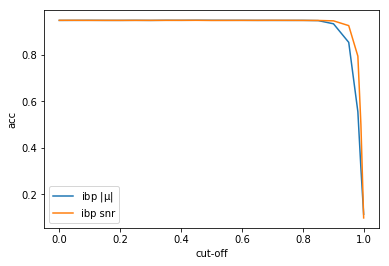

In [19]:
#plt.plot(xs, ya, label='$|\mu|$')
#plt.plot(xs, yb, label='snr')
plt.plot(xs, ya_ibp, label='ibp $|\mu|$')
plt.plot(xs, yb_ibp, label='ibp snr')
plt.xlabel('cut-off')
plt.ylabel('acc')
plt.legend()
plt.show()

# No IBP

In [6]:
class MFVI_NN_prune(MFVI_NN):
    def __init__(self, input_size, hidden_size, output_size, training_size, 
        no_train_samples=10, no_pred_samples=100, prev_means=None, prev_log_variances=None, learning_rate=0.001, 
        prior_mean=0, prior_var=1):

        super(MFVI_NN_prune, self).__init__(input_size, hidden_size, output_size, training_size, 
        no_train_samples, no_pred_samples, prev_means, prev_log_variances, learning_rate, 
        prior_mean, prior_var)


    def prune_weights(self, X_test, Y_test, task_id):
        """ Performs weight pruning.
        
        Z is at a data level doesn't make sense to introduce this intot he mask over weights which get zeroed 
        out. Simlpy running the accuracy over the graph will entail that Z is incorporated into the 
        matrix math for the prediction calculations.
        
        Args:
            X_test: numpy array
            Y_test: numpy array
            task_id: int
        :return: cutoffs, accs via naive pruning, accs via snr pruning,
        weight values, sigma values of network
        """

        def reset_weights(pr_mus, pr_sigmas, _mus, _sigmas):
            """ Reset weights of graph to original values
            Args:
                pr_mus: list of tf variables which have been pruned
                pr_sigmas: list of tf variables which have been pruned
                _mus: list of cached mus in numpy
                _sigmas: list of cached sigmas in numpy
            """

            for v, _v in zip(pr_mus, _mus):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

            for v, _v in zip(pr_sigmas, _sigmas):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

        def pruning(remove_pct, weightvalues, sigmavalues,
                    weights, sigmas, uncert_pruning=True):
            """ Performs weight pruning experiment
            Args:
                weightvalues: np array of weights
                sigmavalues: np array of sigmas
                weights: list of tf weight variable
                sigmas: list of tf sigma variables
                uncert_pruning: bool pruning by snr
            """
            if uncert_pruning:
                sorted_STN = np.sort(np.abs(weightvalues) / sigmavalues)
                
            else:
                sorted_STN = np.sort(np.abs(weightvalues))
            cutoff = sorted_STN[int(remove_pct * len(sorted_STN))]
            
            # Weights, biases and head weights
            for v, s in zip(weights, sigmas):
                if uncert_pruning:
                    snr = tf.abs(v) / tf.exp(0.5*s)
                    mask = tf.greater_equal(snr, cutoff)
                else:
                    mask = tf.greater_equal(tf.abs(v), cutoff)
                self.sess.run(tf.assign(v, tf.multiply(v, tf.cast(mask, v.dtype))))
                
            accs = []
            for _ in range(10):
                accs.append(self.sess.run(self.acc, {self.x: X_test,
                                                     self.y: Y_test,
                                                     self.task_idx: task_id}))
            print("%.2f, %s" % (np.sum(sorted_STN < cutoff) / len(sorted_STN), np.mean(accs)))
            return np.mean(accs)

        # get weights
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # Get weights from network
        mus_w = []
        mus_b = []
        sigmas_w = []
        sigmas_b = []
        mus_h = [] # weights and biases
        sigmas_h = [] # weights and biases
        for v in weights:
            if re.match("^([w])(_mu_)([0-9]+)(:0)$", v.name):
                mus_w.append(v)
            elif re.match("^([w])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_w.append(v)
            elif re.match("^([b])(_mu_)([0-9]+)(:0)$", v.name):
                mus_b.append(v)
            elif re.match("^([b])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_b.append(v)
            elif re.match("^([wb])(_mu_h_)([0-9]+)(:0)$", v.name):
                mus_h.append(v)
            elif re.match("^([wb])(_sigma_h_)([0-9]+)(:0)$", v.name):
                sigmas_h.append(v)
            else:
                print("Un-matched: {}".format(v.name))
                
        # cache network weights of resetting the network
        _mus_w = [self.sess.run(w) for w in mus_w]
        _sigmas_w = [self.sess.run(w) for w in sigmas_w]
        _mus_b = [self.sess.run(w) for w in mus_b]
        _sigmas_b = [self.sess.run(w) for w in sigmas_b]
        _mus_h = [self.sess.run(w) for w in mus_h]
        _sigmas_h = [self.sess.run(w) for w in sigmas_h]
        
        weightvalues = np.hstack(np.array([self.sess.run(w).flatten() for w in mus_w + mus_b + mus_h]))
        sigmavalues = np.hstack(np.array([self.sess.run(tf.exp(0.5*s)).flatten() for s in sigmas_w + sigmas_b + sigmas_h]))
    
        xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
        # pruning
        ya = []
        for pct in xs:
            ya_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                              sigmas_w + sigmas_b + sigmas_h, uncert_pruning=False))

        # reset etc.
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        yb = []
        for pct in xs:
            yb_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                                  sigmas_w + sigmas_b + sigmas_h, uncert_pruning=True))
            
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        
        return xs, ya, yb

In [7]:
hidden_size = [100]
batch_size = 128
no_epochs = 500

tf.set_random_seed(12)
np.random.seed(1)

coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
    
tf.reset_default_graph()  
x_train, y_train, x_test, y_test = data_gen.task()
x_testsets.append(x_test)
y_testsets.append(y_test)

# Set the readout head to train
head = 0 if single_head else task_id
bsize = x_train.shape[0] if (batch_size is None) else batch_size

# Train network with maximum likelihood to initialize first model
if task_id == 0:
    ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
    ml_model.train(x_train, y_train, task_id, 100, bsize)
    mf_weights = ml_model.get_weights()
    mf_variances = None
    ml_model.close_session()

# Train on non-coreset data
mf_model = MFVI_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                         prev_log_variances=mf_variances)

mf_model.train(x_train, y_train, head, no_epochs, bsize)

xs, ya, yb  = mf_model.prune_weights(x_test, y_test, head)

mf_model.close_session()

Epoch: 0001 cost= 0.423908216
Epoch: 0006 cost= 0.074809015
Epoch: 0011 cost= 0.034873054
Epoch: 0016 cost= 0.017029525
Epoch: 0021 cost= 0.008828043
Epoch: 0026 cost= 0.005183751
Epoch: 0031 cost= 0.004760422
Epoch: 0036 cost= 0.000991851
Epoch: 0041 cost= 0.000453620
Epoch: 0046 cost= 0.001089015
Epoch: 0051 cost= 0.000240368
Epoch: 0056 cost= 0.000249355
Epoch: 0061 cost= 0.000135572
Epoch: 0066 cost= 0.011170367
Epoch: 0071 cost= 0.000105972
Epoch: 0076 cost= 0.000064127
Epoch: 0081 cost= 0.000742145
Epoch: 0086 cost= 0.000067122
Epoch: 0091 cost= 0.000039976
Epoch: 0096 cost= 0.003797296
Optimization Finished!
Epoch: 0001 cost= 3.228416839
Epoch: 0006 cost= 2.006878323
Epoch: 0011 cost= 1.208152405
Epoch: 0016 cost= 0.899522673
Epoch: 0021 cost= 0.783278817
Epoch: 0026 cost= 0.700111097
Epoch: 0031 cost= 0.634223401
Epoch: 0036 cost= 0.581039405
Epoch: 0041 cost= 0.532690271
Epoch: 0046 cost= 0.493331300
Epoch: 0051 cost= 0.460849917
Epoch: 0056 cost= 0.432339303
Epoch: 0061 cost=

In [12]:
ya = ya_ibp[len(xs):]
yb = yb_ibp[len(xs):]
ya_ibp = ya_ibp[:len(xs)]
yb_ibp = yb_ibp[:len(xs)]

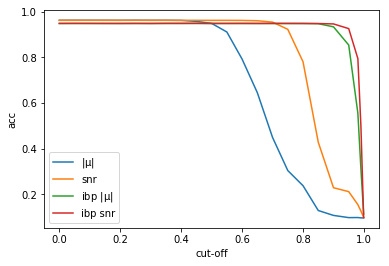

In [20]:
plt.plot(xs, ya, label='$|\mu|$')
plt.plot(xs, yb, label='snr')
plt.plot(xs, ya_ibp, label='ibp $|\mu|$')
plt.plot(xs, yb_ibp, label='ibp snr')
plt.xlabel('cut-off')
plt.ylabel('acc')
plt.legend()
plt.show()

In [21]:
with open('results/weight_pruning.pkl', 'wb') as input_file:
    pickle.dump({'ya_nnvi': ya,
                 'yb_nnvi': yb,
                 'ya_ibp': ya_ibp,
                 'yb_ibp': yb_ibp}, input_file)

# Split

In [ ]:
hidden_size = [100]
batch_size = 128
no_epochs = 200
alpha0 = 1.0
tau0=1.0 # initial temperature
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = False
data_gen = SplitMnistGenerator(val, num_tasks=1)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, x_val, y_val = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:    
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=alpha0,
                           learning_rate=0.01, lambda_1=tau0, lambda_2=1.0, no_pred_samples=100)
    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)
    
    xs, ya, yb, ya_ibp, yb_ibp  = mf_model.prune_weights(x_test, y_test, head)
    
    mf_model.close_session()